# Neural network for inferring atom identities from xyz EDM
Predict whether each atom of an input molecule is a Carbon or Oxygen (concept can be scaled)


In [98]:
## open source toolkit for cheminformatics
##the majority of basic chemical functionality is contained in the chem module
from rdkit import Chem
##more advanced of less frequently used functionalty is in the AllChem Module
##this distinction is made to speed up import time
from rdkit.Chem import AllChem
##module for drawing molecule diagrams
from rdkit.Chem import Draw
##for displaying the molecule in jupyter 
from rdkit.Chem.Draw import IPythonConsole
##Get the 3d points of atoms
from rdkit.Geometry import Point3D
##Progress bars
from tqdm import tqdm_notebook
##pairwise distances between observations in n dimensions
from scipy.spatial.distance import pdist
## convert vectorised distances to distance matrix
from scipy.spatial.distance import squareform
import numpy as np
np.set_printoptions(suppress=True)
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import keras
from keras.layers import Dense, Conv2D, Flatten
import matplotlib.pyplot as plt
%matplotlib inline

In [109]:
#smiles = [i.strip('\n').split()[0] for i in open('../data/GDB4c.smi', 'r').readlines()]
#smiles = [i.strip('\n').split()[0] for i in open('../data/gdb13.rand1M.smi', 'r').readlines()]
##Limit our list of molecules to only those which have seven carbons and two oxygens 
mols = list()
##Import molecules from 
suppl = Chem.SDMolSupplier('qm9/gdb9.sdf')
for mol in tqdm_notebook(suppl):
    if mol:
        if mol.GetNumAtoms()==9:
            atoms = np.array([i.GetAtomicNum() for i in mol.GetAtoms()])
            if np.sum(atoms==6)==7 and np.sum(atoms==8)==2:
                mols.append(mol)

In [3]:
def getEDM(mol):
    #get 3d coords
    m3 = Chem.AddHs(mol)
    embed = AllChem.EmbedMolecule(m3)
    if embed+1:  
        m3 = Chem.RemoveHs(m3)
        conformer = m3.GetConformer(0)
        positions = conformer.GetPositions()
        return positions
    else:
        return None

In [6]:
##Get list of EDMs and Atom IDs
edms = list()
atomidx = list()
for m in tqdm_notebook(mols):
    points = getEDM(m)
    if points is None:
        None
    else:
        edm = pdist(points)
        atoms = np.array([i.GetAtomicNum() for i in m.GetAtoms()])
        edms.append(edm)
        atomidx.append(atoms)

In [10]:
##Encode atom as one hot
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
flatten_atom=np.array(atomidx).flatten().reshape(-1,1)
enc.fit(flatten_atom)

C:\Users\nicka\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


OneHotEncoder(categorical_features=None, categories=None, drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='error',
              n_values=None, sparse=True)

In [63]:
##transform all edms into squareform as this is easy to input into a convnet
edm_inputs=[]
for edm in edms:
    edm_inputs.append(squareform(edm))

14568

In [57]:
#transform one_hot atom_ID into binary
atom_labels=[]
for atom in atomidx:
    atom_labels.append(enc.transform(atom.reshape(-1,1)).toarray()[:,0])

In [85]:
edm_inputs=np.array(edm_inputs)

atom_labels=np.array(atom_labels)


In [90]:
reshaped_edm=np.reshape(np.array(edm_inputs), (14568, 9, 9,1))

In [91]:
X_train=reshaped_edm[:12000]
X_test=reshaped_edm[12000:]
Y_train=atom_labels[:12000]
Y_test= atom_labels[12000:]

In [93]:
##Build multiclass network

model=keras.models.Sequential()
model.add(Conv2D(256, kernel_size=3, activation='relu', input_shape=(9,9,1)))
model.add(Conv2D(256, kernel_size=3, activation='relu'))
model.add(Conv2D(256, kernel_size=3, activation='relu'))
model.add(Flatten())
##use sigmoid instead of softmax as for any molecule there are multiple atoms
##In the final model which can predict more than 2 atoms we will perhaps need multiple outputs 
##with a softmax activation on each independant output
model.add(Dense(9, activation='sigmoid'))

In [110]:
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['acc'])

In [159]:
##If you dont want to retrain the network you can load this checkpoint
model.load_weights('mol_network_weights.hdf5')

In [95]:
history=model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=30)

Train on 12000 samples, validate on 2568 samples
Epoch 1/50
12000/12000 [==============================] - ETA: 1:58 - loss: 0.677 - ETA: 49s - loss: 0.590 - ETA: 35s - loss: 0.57 - ETA: 29s - loss: 0.57 - ETA: 26s - loss: 0.56 - ETA: 23s - loss: 0.55 - ETA: 22s - loss: 0.54 - ETA: 21s - loss: 0.54 - ETA: 20s - loss: 0.54 - ETA: 19s - loss: 0.53 - ETA: 19s - loss: 0.53 - ETA: 18s - loss: 0.53 - ETA: 18s - loss: 0.53 - ETA: 17s - loss: 0.52 - ETA: 17s - loss: 0.52 - ETA: 17s - loss: 0.52 - ETA: 16s - loss: 0.52 - ETA: 16s - loss: 0.51 - ETA: 16s - loss: 0.51 - ETA: 16s - loss: 0.51 - ETA: 15s - loss: 0.51 - ETA: 15s - loss: 0.51 - ETA: 15s - loss: 0.51 - ETA: 15s - loss: 0.50 - ETA: 15s - loss: 0.50 - ETA: 14s - loss: 0.50 - ETA: 14s - loss: 0.50 - ETA: 14s - loss: 0.49 - ETA: 14s - loss: 0.49 - ETA: 14s - loss: 0.49 - ETA: 14s - loss: 0.49 - ETA: 14s - loss: 0.49 - ETA: 14s - loss: 0.49 - ETA: 13s - loss: 0.48 - ETA: 13s - loss: 0.48 - ETA: 13s - loss: 0.48 - ETA: 13s - loss: 0.48 - ET

12000/12000 [==============================] - ETA: 15s - loss: 0.16 - ETA: 15s - loss: 0.18 - ETA: 15s - loss: 0.18 - ETA: 14s - loss: 0.18 - ETA: 14s - loss: 0.18 - ETA: 14s - loss: 0.18 - ETA: 14s - loss: 0.18 - ETA: 14s - loss: 0.18 - ETA: 14s - loss: 0.18 - ETA: 14s - loss: 0.18 - ETA: 14s - loss: 0.18 - ETA: 14s - loss: 0.18 - ETA: 14s - loss: 0.18 - ETA: 14s - loss: 0.18 - ETA: 14s - loss: 0.18 - ETA: 14s - loss: 0.18 - ETA: 14s - loss: 0.18 - ETA: 13s - loss: 0.18 - ETA: 13s - loss: 0.18 - ETA: 13s - loss: 0.18 - ETA: 13s - loss: 0.18 - ETA: 13s - loss: 0.18 - ETA: 13s - loss: 0.18 - ETA: 13s - loss: 0.18 - ETA: 13s - loss: 0.18 - ETA: 13s - loss: 0.18 - ETA: 13s - loss: 0.18 - ETA: 13s - loss: 0.18 - ETA: 12s - loss: 0.18 - ETA: 12s - loss: 0.18 - ETA: 12s - loss: 0.18 - ETA: 12s - loss: 0.18 - ETA: 12s - loss: 0.18 - ETA: 12s - loss: 0.18 - ETA: 12s - loss: 0.18 - ETA: 12s - loss: 0.18 - ETA: 12s - loss: 0.18 - ETA: 12s - loss: 0.18 - ETA: 12s - loss: 0.18 - ETA: 12s - loss: 

12000/12000 [==============================] - ETA: 16s - loss: 0.12 - ETA: 15s - loss: 0.12 - ETA: 15s - loss: 0.12 - ETA: 15s - loss: 0.12 - ETA: 15s - loss: 0.12 - ETA: 15s - loss: 0.12 - ETA: 15s - loss: 0.12 - ETA: 15s - loss: 0.12 - ETA: 15s - loss: 0.12 - ETA: 15s - loss: 0.12 - ETA: 15s - loss: 0.12 - ETA: 15s - loss: 0.12 - ETA: 15s - loss: 0.12 - ETA: 15s - loss: 0.12 - ETA: 14s - loss: 0.11 - ETA: 14s - loss: 0.12 - ETA: 14s - loss: 0.11 - ETA: 14s - loss: 0.11 - ETA: 14s - loss: 0.11 - ETA: 14s - loss: 0.11 - ETA: 14s - loss: 0.11 - ETA: 14s - loss: 0.11 - ETA: 13s - loss: 0.11 - ETA: 14s - loss: 0.11 - ETA: 14s - loss: 0.11 - ETA: 13s - loss: 0.11 - ETA: 13s - loss: 0.11 - ETA: 13s - loss: 0.11 - ETA: 13s - loss: 0.11 - ETA: 13s - loss: 0.11 - ETA: 13s - loss: 0.11 - ETA: 13s - loss: 0.11 - ETA: 13s - loss: 0.11 - ETA: 13s - loss: 0.11 - ETA: 13s - loss: 0.11 - ETA: 13s - loss: 0.11 - ETA: 13s - loss: 0.11 - ETA: 13s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 

12000/12000 [==============================] - ETA: 16s - loss: 0.04 - ETA: 19s - loss: 0.06 - ETA: 17s - loss: 0.05 - ETA: 16s - loss: 0.05 - ETA: 16s - loss: 0.05 - ETA: 16s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.06 - ETA: 15s - loss: 0.06 - ETA: 15s - loss: 0.06 - ETA: 14s - loss: 0.06 - ETA: 14s - loss: 0.06 - ETA: 14s - loss: 0.06 - ETA: 14s - loss: 0.06 - ETA: 14s - loss: 0.06 - ETA: 14s - loss: 0.06 - ETA: 14s - loss: 0.06 - ETA: 14s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 12s - loss: 

12000/12000 [==============================] - ETA: 15s - loss: 0.03 - ETA: 15s - loss: 0.04 - ETA: 15s - loss: 0.04 - ETA: 15s - loss: 0.04 - ETA: 15s - loss: 0.04 - ETA: 15s - loss: 0.04 - ETA: 14s - loss: 0.04 - ETA: 14s - loss: 0.04 - ETA: 14s - loss: 0.04 - ETA: 14s - loss: 0.04 - ETA: 14s - loss: 0.04 - ETA: 14s - loss: 0.04 - ETA: 14s - loss: 0.04 - ETA: 14s - loss: 0.04 - ETA: 14s - loss: 0.04 - ETA: 14s - loss: 0.04 - ETA: 14s - loss: 0.04 - ETA: 14s - loss: 0.04 - ETA: 14s - loss: 0.04 - ETA: 13s - loss: 0.04 - ETA: 13s - loss: 0.04 - ETA: 13s - loss: 0.04 - ETA: 13s - loss: 0.04 - ETA: 13s - loss: 0.04 - ETA: 13s - loss: 0.04 - ETA: 13s - loss: 0.04 - ETA: 13s - loss: 0.04 - ETA: 13s - loss: 0.04 - ETA: 13s - loss: 0.04 - ETA: 13s - loss: 0.04 - ETA: 13s - loss: 0.04 - ETA: 13s - loss: 0.04 - ETA: 12s - loss: 0.04 - ETA: 12s - loss: 0.04 - ETA: 12s - loss: 0.04 - ETA: 12s - loss: 0.04 - ETA: 12s - loss: 0.04 - ETA: 12s - loss: 0.04 - ETA: 12s - loss: 0.04 - ETA: 12s - loss: 

12000/12000 [==============================] - ETA: 15s - loss: 0.04 - ETA: 15s - loss: 0.04 - ETA: 15s - loss: 0.04 - ETA: 15s - loss: 0.04 - ETA: 15s - loss: 0.03 - ETA: 15s - loss: 0.03 - ETA: 15s - loss: 0.04 - ETA: 15s - loss: 0.04 - ETA: 15s - loss: 0.04 - ETA: 15s - loss: 0.03 - ETA: 15s - loss: 0.03 - ETA: 15s - loss: 0.03 - ETA: 15s - loss: 0.03 - ETA: 15s - loss: 0.03 - ETA: 15s - loss: 0.03 - ETA: 14s - loss: 0.03 - ETA: 14s - loss: 0.03 - ETA: 14s - loss: 0.03 - ETA: 14s - loss: 0.03 - ETA: 14s - loss: 0.03 - ETA: 14s - loss: 0.03 - ETA: 14s - loss: 0.03 - ETA: 14s - loss: 0.03 - ETA: 13s - loss: 0.03 - ETA: 13s - loss: 0.03 - ETA: 13s - loss: 0.03 - ETA: 13s - loss: 0.03 - ETA: 13s - loss: 0.03 - ETA: 13s - loss: 0.03 - ETA: 13s - loss: 0.03 - ETA: 13s - loss: 0.03 - ETA: 13s - loss: 0.03 - ETA: 13s - loss: 0.03 - ETA: 13s - loss: 0.03 - ETA: 13s - loss: 0.03 - ETA: 13s - loss: 0.03 - ETA: 13s - loss: 0.03 - ETA: 12s - loss: 0.03 - ETA: 12s - loss: 0.03 - ETA: 12s - loss: 

12000/12000 [==============================] - ETA: 14s - loss: 0.02 - ETA: 15s - loss: 0.02 - ETA: 15s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 13s - loss: 0.02 - ETA: 13s - loss: 0.02 - ETA: 13s - loss: 0.02 - ETA: 13s - loss: 0.02 - ETA: 13s - loss: 0.02 - ETA: 13s - loss: 0.02 - ETA: 13s - loss: 0.02 - ETA: 13s - loss: 0.02 - ETA: 13s - loss: 0.02 - ETA: 13s - loss: 0.02 - ETA: 13s - loss: 0.02 - ETA: 13s - loss: 0.02 - ETA: 13s - loss: 0.02 - ETA: 12s - loss: 0.02 - ETA: 12s - loss: 0.02 - ETA: 12s - loss: 0.02 - ETA: 12s - loss: 0.02 - ETA: 12s - loss: 0.02 - ETA: 12s - loss: 0.02 - ETA: 12s - loss: 0.02 - ETA: 12s - loss: 0.02 - ETA: 12s - loss: 0.02 - ETA: 12s - loss: 0.02 - ETA: 12s - loss: 0.02 - ETA: 12s - loss: 

12000/12000 [==============================] - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.02 - ETA: 15s - loss: 0.02 - ETA: 15s - loss: 0.02 - ETA: 15s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 13s - loss: 0.02 - ETA: 13s - loss: 0.02 - ETA: 13s - loss: 0.02 - ETA: 13s - loss: 0.02 - ETA: 13s - loss: 0.02 - ETA: 13s - loss: 0.02 - ETA: 13s - loss: 0.02 - ETA: 13s - loss: 0.02 - ETA: 13s - loss: 0.02 - ETA: 13s - loss: 0.02 - ETA: 13s - loss: 0.02 - ETA: 13s - loss: 0.02 - ETA: 13s - loss: 0.02 - ETA: 13s - loss: 0.02 - ETA: 13s - loss: 0.02 - ETA: 12s - loss: 0.02 - ETA: 12s - loss: 0.02 - ETA: 12s - loss: 0.02 - ETA: 12s - loss: 0.02 - ETA: 12s - loss: 0.03 - ETA: 12s - loss: 0.03 - ETA: 12s - loss: 

12000/12000 [==============================] - ETA: 16s - loss: 0.07 - ETA: 15s - loss: 0.03 - ETA: 15s - loss: 0.03 - ETA: 15s - loss: 0.03 - ETA: 15s - loss: 0.02 - ETA: 15s - loss: 0.02 - ETA: 15s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 15s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 13s - loss: 0.02 - ETA: 13s - loss: 0.02 - ETA: 13s - loss: 0.02 - ETA: 13s - loss: 0.02 - ETA: 13s - loss: 0.02 - ETA: 13s - loss: 0.02 - ETA: 13s - loss: 0.02 - ETA: 13s - loss: 0.02 - ETA: 13s - loss: 0.02 - ETA: 13s - loss: 0.02 - ETA: 13s - loss: 0.02 - ETA: 13s - loss: 0.02 - ETA: 12s - loss: 0.02 - ETA: 12s - loss: 0.02 - ETA: 12s - loss: 0.02 - ETA: 12s - loss: 0.01 - ETA: 12s - loss: 0.01 - ETA: 12s - loss: 0.01 - ETA: 12s - loss: 0.01 - ETA: 12s - loss: 

12000/12000 [==============================] - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 12s - loss: 0.01 - ETA: 12s - loss: 0.01 - ETA: 12s - loss: 

12000/12000 [==============================] - ETA: 15s - loss: 0.02 - ETA: 15s - loss: 0.02 - ETA: 15s - loss: 0.02 - ETA: 15s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 12s - loss: 0.01 - ETA: 12s - loss: 0.01 - ETA: 12s - loss: 0.01 - ETA: 12s - loss: 0.01 - ETA: 12s - loss: 0.01 - ETA: 12s - loss: 0.01 - ETA: 12s - loss: 0.01 - ETA: 12s - loss: 0.01 - ETA: 12s - loss: 

12000/12000 [==============================] - ETA: 16s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 12s - loss: 0.01 - ETA: 12s - loss: 0.01 - ETA: 12s - loss: 0.01 - ETA: 12s - loss: 0.01 - ETA: 12s - loss: 0.01 - ETA: 12s - loss: 0.01 - ETA: 12s - loss: 

KeyboardInterrupt: 

In [157]:
#The model infers the correct atom ID from the structure 98% of the time
model.evaluate(X_test, Y_test)

2568/2568 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 524us/step


[0.057316847886843755, 0.9823900461196899]

In [114]:
plt.plot(history.history['binary_crossentropy'])
plt.plot(history.history['val_binary_crossentropy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

In [117]:
load_array=np.load('Molecule_EDM.npy')

In [119]:
gmm_gen=squareform(load_array)

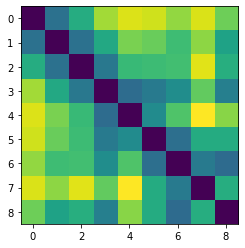

In [122]:
gmm_gen = gmm_gen-np.min(gmm_gen)
plt.imshow(gmm_gen)

In [154]:
atoms_predicted=np.around(model.predict(gmm_gen.reshape(1,9,9,1)))

In [130]:
##https://math.stackexchange.com/questions/156161/finding-the-coordinates-of-points-from-distance-matrix
##good explanation here :)
def to_M_matrix(D):
    D1j = np.tile(D[0, :], len(D)).reshape(D.shape)
    Di1 = D1j.T
    return .5 * (-D + D1j + Di1)

def setPositions(mol_in, coords):
    conformer = mol_in.GetConformer(0)
    for i in range(mol_in.GetNumAtoms()):
        x,y,z = coords[i]
        conformer.SetAtomPosition(i,Point3D(x,y,z))
    return mol_in

D = gmm_gen**2
M = to_M_matrix(D)
S, U = np.linalg.eigh(M)

coord = np.matmul(U, np.diag(np.sqrt(np.abs(S))))
X = coord[:, -3:]


In [132]:
X

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.72486152,  0.24353741, -1.03701062],
       [ 0.93052893,  1.13994873, -1.78140723],
       [ 0.43532283,  0.83346384, -3.24793529],
       [-0.93894008,  1.7068391 , -3.09527104],
       [-0.78642922,  0.06978843, -3.46658352],
       [-0.02172932, -0.89918999, -3.08270031],
       [-0.36182012, -2.0468954 , -2.95940617],
       [ 1.10837416, -0.6340417 , -2.65886192]])

In [155]:
one_hot_atoms=np.column_stack(((((atoms_predicted)[0])),abs(((atoms_predicted)[0])-1)))
atomidentities=enc.inverse_transform(one_hot_atoms)

In [156]:
atomstring = ''
for atom in atomidentities:
    if atom<7:
        atomstring=atomstring+'C'
    else:
        atomstring=atomstring+'O'

tempmol = Chem.MolFromSmiles(atomstring)
tempmol = Chem.AddHs(tempmol)
embed = AllChem.EmbedMolecule(tempmol)
tempmol = Chem.RemoveHs(tempmol)

m3 = setPositions(tempmol, X)
Chem.rdmolfiles.MolToPDBFile(m3, 'tempmol.pdb', flavor=2)